In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

In [ ]:
# Load log file
names = ["chip", "time", "addr", "operation", "mask", "wl_dac_lvl", "bsl_dac_lvl", "sa_do", "ignore"]
formdata = pd.read_csv("../data/form.5mhz.188cell.csv", names=names, index_col=False)
formdata.sa_do = formdata.sa_do.shift(-1, fill_value=0)
formdata["nform"] = formdata.sa_do.apply(lambda di: bin(di).count("1"))
formdata = formdata[formdata.operation == "SET"]

# Figure
plt.figure(figsize=(5,3))
formdata[formdata.operation == "SET"].groupby("wl_dac_lvl").sum()["nform"].plot.bar(width=1)
plt.title("FORM-Inducing WL DAC Statistics (188x48 cells)")
plt.xlabel("WL DAC Level")
plt.ylabel("Frequency")
plt.text(100, 100, "bl_dac_lvl=31\nclk=5MHz\npw=3us\nread_dac_lvl=7\nclamp_ref_lvl=1\nform_thresh=32")
plt.locator_params(nbins=10)
plt.tight_layout()
plt.savefig("figs/form.wl.stats.pdf")

In [ ]:
# Load log file
names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
formreaddata = pd.read_csv("../data/formread.5mhz.188cell.csv", names=names, index_col=False, delimiter="\t")

# Figure
plt.figure(figsize=(5,3))
plt.bar(np.arange(2, 64, 4), np.bincount(formreaddata[formreaddata.columns[-48:]].values.flatten()), width=4)
plt.title("Post-FORM READ Statistics (188x48 cells)")
plt.xlabel("READ Ref Level")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("figs/form.read.stats.pdf")

In [ ]:
# Produce checkerboard plots for 1-4 bpc
confmats = []
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(5,4))
for bpc in range(1, 5):
  # Subplot
  plt.subplot(220 + bpc)

  # Load data
  names = ["addr", "time"] + ["read_" + str(i) for i in range(48)]
  data = pd.read_csv(f"../data/{bpc}bpc.csv", sep="\t", names=names)

  # Show multi-bit result
  matdata = data[data.columns[-48:]].values[:48]
  im = plt.imshow(matdata, vmin=0, vmax=2**bpc-1)
  cbar = plt.colorbar(im, fraction=0.04, pad=0.04)
  if bpc != 4:
    cbar.set_ticks(range(2**bpc))
  # cbar.set_label("READ Value")
  plt.title(f"{bpc}bpc", x=0.5, y=0.5, verticalalignment="center", horizontalalignment="center", backgroundcolor="white", fontweight="bold")
  if bpc > 2:
    plt.xlabel("Bit Index")
  if bpc % 2 == 1:
    plt.ylabel("Address")

  # Load data into confmat
  confmat = np.zeros(shape=(2**bpc, 2**bpc))
  for i in range(48):
    for j in range(48):
      confmat[(data["addr"][i] + j) % (2**bpc)][matdata[i][j]] += 1
  confmat = confmat.astype(int)
  print(confmat)

  # Symbol error magnitudes
  mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
  rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

  # Function to get Gray code string
  getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

  # Function to get Gray code error rate for each possible symbol confusion
  grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc
  # print(grayerr)

  # BER
  ber = (grayerr * confmat).sum() / confmat.sum()
  plt.text(0.5*48, 0.7*48, f"Gray BER = " + format(ber*100, ".2f") + "%\nLinear RMSE = " + format(rmse, ".2f"), fontsize=8, verticalalignment="center", horizontalalignment="center", backgroundcolor="white")

  # Set ticks
  plt.xticks([0,16,32,47])
  plt.yticks([0,16,32,47])
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.5)
plt.tight_layout()
plt.savefig(f"figs/cb.pdf")
plt.show()

def binary_to_gray_op(n):
  n = int(n, 2)
  n ^= (n >> 1)
  return bin(n)[2:]

In [ ]:
# Plot conductance ranges
import json
settings = json.load(open("../settings/2bpc.json"))
plt.axvline(0, 0, 1, color='r')
for level in settings["level_settings"]:
    plt.axvline(level["adc_upper_read_ref_lvl"], 0, 1, color='r')
    plt.axvline(level["adc_lower_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
    plt.axvline(level["adc_upper_write_ref_lvl"], 0, 0.5, color='g', linestyle='--')
plt.xlim(-0.5, 63.5)
plt.gca().get_yaxis().set_visible(False)

In [ ]:
names = ["addr", "i", "Cycle #", "RESET", "SET"]
data = pd.read_csv(f"../data/endurance.csv.gz", delimiter='\t', names=names)
data = data[data["addr"] == 10900]
data = data[data["i"] == 9]
plt.rcParams["figure.figsize"] = (5,3)
data.groupby("i").plot("Cycle #", ["SET", "RESET"], title="Endurance Cycling Behavior", ylabel="ADC Level")
plt.tight_layout()
plt.savefig("figs/endurance.pdf")
plt.show()

In [ ]:
# Load retention time data
tdata = pd.read_csv("../data/retention2.min.csv.gz")
tdata

In [ ]:
# Plot sigma-mu
%matplotlib inline
times = [0, 0.1, 1, 10, 100, 1000, 10000, 100000]
for time in times:
    sbadata = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))].groupby("lvli")["lvl"].std()
    sbadata.plot(label=f"data,t={time}")
    fit = np.polyfit(sbadata.index.values, sbadata.values, 3)
    print(np.poly1d(fit))
    plt.plot(range(4,64), np.poly1d(fit)(range(4,64)), '--', label=f"fit,t={time}")
plt.title("Sigma-Mu Plot for SBA")
plt.xlabel("Programmed Level")
plt.ylabel("Stdev. of READ Level")
# plt.legend()
plt.tight_layout()
plt.savefig("figs/sigmamu.pdf")
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [9, 4]
tdata.groupby("lvli").count()["lvl"].plot.bar()
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Show distribution
time = 100
plt.rcParams["figure.figsize"] = [6, 4]
plt.title("MLC Distributions (1024 cells w/64 levels, ~3hrs)")
d = tdata[(tdata["timept"] == time) & tdata["lvli"].isin(range(0,64,1))]
for i in range(64):
    rdata = d[d["lvli"] == i]
    if len(rdata) != 0:
        plt.plot(sorted(rdata["lvl"].values), np.linspace(0+1/len(rdata), 1-1/len(rdata), len(rdata)), label=i)
plt.xlabel("Programmed Level")
plt.ylabel("CDF")
plt.gca().set_yscale("ppf")
plt.xlim(0, 64)
plt.ylim(0.001, 0.999)
plt.tight_layout()
plt.show()



In [2]:
# Set VDDIO (times 10)
vddio = 33

In [ ]:
# SET sweep data
setdata = pd.read_csv(f"../data/setsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
setdata

In [ ]:
setdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("SET Sweep Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

In [ ]:
for pw in setdata["pw"].unique():
    d = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)][["vwl","vbl","pw","gf"]]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=7, azim=-26)
    ax.scatter3D(d['vbl'], d['vwl'], d['gf'], c=d['vbl'])
    plt.savefig(f"figs/set_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

In [ ]:
for pw in setdata["pw"].unique():
    setdatamean = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)].groupby(["vwl","vbl","pw"])["gf"].mean().reset_index()
    d = setdatamean[setdatamean["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Mean Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=7, azim=-26)
    ax.plot_trisurf(d['vbl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/set_sweep_{vddio}_mean_{str(pw).zfill(4)}.png", dpi=300)

    setdatastd = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == pw)].groupby(["vwl","vbl","pw"])["gf"].std().reset_index()
    d = setdatastd[setdatastd["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"SET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("BL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Stdev. Final ADC Level")
    ax.set_zlim(0, 8)
    ax.view_init(elev=7, azim=-26)
    ax.plot_trisurf(d['vbl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/set_sweep_{vddio}_std_{str(pw).zfill(4)}.png", dpi=300)

In [ ]:
# Reset sweep data
resetdata = pd.read_csv(f"../data/resetsweep{vddio}.csv", delimiter="\t", names=["addr", "t", "vwl", "vsl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
resetdata = pd.concat([resetdata[["addr","t","vwl","vsl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
resetdata

In [ ]:
plt.figure()
resetdata["gi"].plot.hist(bins=np.arange(-0.5, 65.5))
plt.title("RESET Sweep Sampling Frequency")
plt.xlabel("Initial ADC Level")
plt.show()

In [ ]:
for pw in resetdata["pw"].unique():
    d = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)][["vwl","vsl","pw","gf"]]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=21, azim=42)
    ax.scatter3D(d['vsl'], d['vwl'], d['gf'], c=d['vsl'])
    plt.savefig(f"figs/reset_sweep_{vddio}_{str(pw).zfill(4)}.png", dpi=300)

In [ ]:
for pw in resetdata["pw"].unique():
    resetdatamean = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)].groupby(["vwl","vsl","pw"])["gf"].mean().reset_index()
    d = resetdatamean[resetdatamean["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Mean Final ADC Level")
    ax.set_zlim(0, 64)
    ax.view_init(elev=21, azim=42)
    ax.plot_trisurf(d['vsl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/reset_sweep_{vddio}_mean_{str(pw).zfill(4)}.png", dpi=300)
    
    resetdatastd = resetdata[(resetdata["gi"].isin(range(55,59))) & (resetdata["pw"] == pw)].groupby(["vwl","vsl","pw"])["gf"].std().reset_index()
    d = resetdatastd[resetdatastd["pw"] == pw]
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_title(f"RESET Sweep (VDAC = {vddio/10}, PW = {pw*10}ns)")
    ax.set_xlabel("SL DAC Level")
    ax.set_ylabel("WL DAC Level")
    ax.set_zlabel("Stdev. Final ADC Level")
    ax.set_zlim(0, 12)
    ax.view_init(elev=21, azim=42)
    ax.plot_trisurf(d['vsl'], d['vwl'], d['gf'], label=f"pw={pw}")
    plt.savefig(f"figs/reset_sweep_{vddio}_std_{str(pw).zfill(4)}.png", dpi=300)


In [4]:
# Load data
edatas = []
for i in range(3):
    vs = ["vdd", "vdd_dac", "vsa", "vddio", "vddio_dac"]
    edata = pd.read_csv(f"../data/setenergy{vddio}_x{i}.csv", delimiter="\t", names=["time", "vwl", "vbl", "pw", "i(vdd)", "i(vdd_dac)", "i(vsa)", "i(vddio)", "i(vddio_dac)", "v(vddio)", "v(vddio_dac)"])
    edata["v(vdd)"] = edata["v(vdd_dac)"] = edata["v(vsa)"] = 0.9
    for v in vs:
      edata[f"p({v})"] = edata[f"v({v})"] * edata[f"i({v})"]
    edata["totpow"] = sum([edata[f"p({v})"] for v in vs])
    edata["n"] = i
    edatas.append(edata)
edata = pd.concat(edatas)
edata

,time,vwl,vbl,pw,i(vdd),i(vdd_dac),i(vsa),i(vddio),i(vddio_dac),v(vddio),...,v(vdd),v(vdd_dac),v(vsa),p(vdd),p(vdd_dac),p(vsa),p(vddio),p(vddio_dac),totpow,n
0,1.686634e+09,0,0,3968,0.000090,0.000092,0.000090,0.001058,0.000389,3.29994,...,0.9,0.9,0.9,0.000081,0.000083,0.000081,0.003492,0.001283,0.005021,0
1,1.686634e+09,0,4,3968,0.000090,0.000091,0.000090,0.001060,0.000389,3.29994,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.003499,0.001286,0.005028,0
2,1.686634e+09,0,8,3968,0.000090,0.000092,0.000090,0.001078,0.000388,3.29994,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.003556,0.001282,0.005082,0
3,1.686634e+09,0,12,3968,0.000089,0.000091,0.000090,0.001053,0.000389,3.29994,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.003475,0.001283,0.005001,0
4,1.686634e+09,0,16,3968,0.000090,0.000091,0.000090,0.001084,0.000389,3.29994,...,0.9,0.9,0.9,0.000081,0.000082,0.000081,0.003577,0.001283,0.005104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,1.686644e+09,255,16,3968,0.000090,0.000091,0.000062,0.001851,0.000376,3.30005,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.006107,0.001242,0.007568,2
149,1.686644e+09,255,20,3968,0.000090,0.000091,0.000062,0.001912,0.000378,3.30005,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.006309,0.001248,0.007776,2
150,1.686644e+09,255,24,3968,0.000090,0.000091,0.000062,0.001949,0.000379,3.30005,...,0.9,0.9,0.9,0.000081,0.000082,0.000056,0.006431,0.001251,0.007900,2
151,1.686644e+09,255,28,3968,0.000076,0.000080,0.000062,0.001985,0.000379,3.30005,...,0.9,0.9,0.9,0.000069,0.000072,0.000056,0.006552,0.001252,0.008001,2


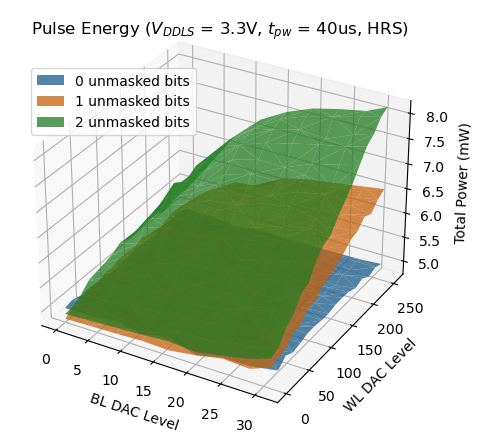

In [5]:
fig = plt.figure(figsize=(5.5, 4.5))
ax = plt.axes(projection='3d')
ax.set_title(f"Pulse Energy ($V_{{DDLS}}$ = {vddio/10}V, $t_{{pw}}$ = 40us, HRS)", y=1)
ax.set_xlabel("BL DAC Level")
ax.set_ylabel("WL DAC Level")
ax.set_zlabel("Total Power (mW)")
for i in range(3):
    e = edata[edata['n'] == i]
    surf = ax.plot_trisurf(e['vbl'], e['vwl'], e['totpow'] * 1000, label=f"{i} unmasked bits", alpha=0.75)
    surf._facecolors2d = surf._facecolor3d
    surf._edgecolors2d = surf._edgecolor3d
ax.legend(loc=(0.05, 0.7))
plt.tight_layout()
plt.savefig("figs/setenergy33.pdf")
plt.show()